In [1]:
#d={"q3dten":q3dtenL_,"th3dten":th3dtenL_,"w3d":w3dL_,"q3d":q3dL_,"th3d":th3dL_,"prs":prsL_}
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

with nc.Dataset("mcs_ten.nc") as f:
    q3dten=f.variables["q3dten"][:]
    th3dten=f.variables["th3dten"][:]
    w3d=f.variables["w3d"][:]
    q3d=f.variables["q3d"][:]
    th3d=f.variables["th3d"][:]
    prs=f.variables["prs"][:]
    #timeL=f.variables["time"][:]



In [3]:

with nc.Dataset('cm1out.nc','r') as f:
    zh=f['zh'][:]
    zf=f['zf'][:]
    xh=f['xh'][:]
    qr=f['qr'][:]

In [2]:
print(th3d.shape)
print(th3d[-1,100,5,:])
rho=prs/(287.05*th3d)
print(rho[-1,100,5,:])
print(prs[-1,100,5,:10])
zf=np.array([0.0, 0.125, 0.25, 0.37500003, 0.5, 0.625, 0.75000006, 0.87500006, 1.0, 1.125, 1.25, 1.3750001, 1.5000001, 1.6250001, 1.7500001, 1.8750001, 2.0, 2.125, 2.261364, 2.409091, 2.568182, 2.7386365, 2.9204547, 3.1136367, 3.318182, 3.534091, 3.761364, 4.0, 4.25, 4.5, 4.75, 5.0, 5.2500005, 5.5000005, 5.7500005, 6.0000005, 6.2500005, 6.5000005, 6.7500005, 7.0000005, 7.2500005, 7.5000005, 7.7500005, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.250001, 10.500001, 10.750001, 11.000001, 11.250001, 11.500001, 11.750001, 12.000001, 12.250001, 12.500001, 12.750001, 13.000001, 13.250001, 13.500001, 13.750001, 14.000001, 14.250001, 14.500001, 14.750001, 15.000001, 15.250001, 15.500001, 15.750001, 16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, 17.75, 18.0, 18.25, 18.5, 18.75])
q3dtot_tend=np.sum(q3dten[:,:,:,:,0:6],axis=-1)

(240, 128, 10, 86)
[300.4632  299.86346 299.1612  298.23535 297.6086  296.8849  296.2033
 295.38773 294.471   293.5128  292.55643 291.61554 290.66653 289.72464
 288.794   287.86172 287.00305 286.44315 285.8649  284.9757  283.93958
 282.7333  281.37256 279.86575 278.26257 276.6048  275.11798 274.13892
 273.65024 271.90155 269.75882 267.55112 265.30594 262.99377 260.64966
 258.34738 256.2591  254.73824 253.54758 252.33057 250.9192  249.28288
 247.48515 245.63905 243.85486 242.20573 240.62491 238.90627 236.969
 234.89339 232.95415 231.5254  230.43768 228.01868 225.95866 224.09366
 222.24326 220.82443 219.20163 217.13312 215.43904 214.09743 211.87886
 209.86319 208.38628 207.13269 204.90234 202.60574 200.55925 199.47388
 201.13777 202.31401 201.84795 202.82794 205.09818 206.52354 206.84207
 206.65994 206.28795 205.954   205.9282  206.39098 207.1776  207.86127
 208.26877 208.50383]
[1.0993411540985107 1.070474624633789 1.0421888828277588
 1.0210775136947632 1.0085786581039429 0.996523082256

In [4]:
dz=zf[1:]-zf[:-1]
it=-1
i1=60
j1=5
from numba import jit

dq_dt=q3dtot_tend[:,:,:,:].copy()*0.0
nz=dq_dt.shape[-1]
for k in range(nz-2,-1,-1):
    dq_dt[:,:,:,k]=dq_dt[:,:,:,k+1]+q3dtot_tend[:,:,:,k]*dz[k]*rho[:,:,:,k] # need a rho here


In [6]:
nt,nx,ny,nz=dq_dt.shape
x_phy=np.stack([prs/1e5,(th3d-273.15),q3d[:,:,:,:,1:6].sum(axis=-1),q3d[:,:,:,:,0]],axis=-1)

#x_reshaped=x[:,:64,:].reshape(nt*nx*ny,64)

In [7]:
dq_dt=-dq_dt
print(dq_dt.max(),dq_dt.min())

0.00045944384 -3.955491e-06


In [38]:
a=np.nonzero(dq_dt>0.1e-6)
print(len(a[0]))
fluxTb=np.zeros((120,210))
cfluxTb=np.zeros((120,210))
for it,i1,j1,k1 in zip(a[0],a[1],a[2],a[3]):
    it1=int((-x_phy[it,i1,j1,k1,1])+30)
    iq=int(x_phy[it,i1,j1,k1,2]/0.00005)
    #print(it1,iq,x_phy[it,i1,j1,k1,1],x_phy[it,i1,j1,k1,2])
    #stop
    if it1<0 or it1>119 or iq<0 or iq>209:
        continue
    fluxTb[it1,iq]+=dq_dt[it,i1,j1,k1]
    cfluxTb[it1,iq]+=1
    
fluxTb[cfluxTb>0]=fluxTb[cfluxTb>0]/cfluxTb[cfluxTb>0]

9472432


In [108]:
import numpy as np
aq=np.nonzero(q3d[:,:,:,:,0]>0.1e-6)
print(len(aq[0]))
cond=np.zeros((120,180))
ccond=np.zeros((120,180))
import saturation as sat
mccount=0
dccount=0
sat_ratio=[]
cond_qvqvs=np.zeros((120,180))
np1=10000000
xL=[]
yL=[]
ymL=[]
for it,i1,j1,k1 in zip(aq[0][:np1],aq[1][:np1],aq[2][:np1],aq[3][:np1]):
    qvs,qvi = sat.saturation(th3d[it,i1,j1,k1],prs[it,i1,j1,k1])
    xL.append([q3d[it,i1,j1,k1,0]/qvs,q3d[it,i1,j1,k1,0]/0.001,(th3d[it,i1,j1,k1]-273.15)/10,\
              prs[it,i1,j1,k1]/1e5,q3d[it,i1,j1,k1,1:6].sum()/0.001])
    ymL.append([q3dten[it,i1,j1,k1,0],th3dten[it,i1,j1,k1],w3d[it,i1,j1,k1]])
    yL.append([q3dten[it,i1,j1,k1,0],th3dten[it,i1,j1,k1],w3d[it,i1,j1,k1]])
    if q3dten[it,i1,j1,k1,0]<0:
        mccount+=1
        qvs,qvi = sat.saturation(th3d[it,i1,j1,k1],prs[it,i1,j1,k1])
        sat_ratio.append(q3d[it,i1,j1,k1,0]/qvs)
        cond[it1,iq]+=q3dten[it,i1,j1,k1,0]
        cond_qvqvs[it1,iq]+=q3d[it,i1,j1,k1,0]/qvs
        ccond[it1,iq]+=1

cond[ccond>0]=cond[ccond>0]/ccond[ccond>0]
cond_qvqvs[ccond>0]=cond_qvqvs[ccond>0]/ccond[ccond>0]


26419200


In [110]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
xL=np.array(xL)
yL=np.array(yL)
ymL=np.array(ymL)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test,ym_train,ym_test = train_test_split(xL, yL[:,0], ymL,test_size=0.2, random_state=0)
histGradRegressor=HistGradientBoostingRegressor(max_iter=3000,max_bins=255,learning_rate=0.1)
histGradRegressor.fit(x_train,2e3*y_train)

HistGradientBoostingRegressor(max_iter=3000)

In [84]:
#gradBoostingRegressor=GradientBoostingRegressor(max_depth=10,n_estimators=1000,learning_rate=0.1)
#gradBoostingRegressor.fit(x_train,y_train)
#print(dir(histGradRegressor))
print(histGradRegressor.max_bins)
print(histGradRegressor.max_depth)
import lightgbm as lgb 

lgb_model=lgb.LGBMRegressor(max_depth=10,n_estimators=1000,learning_rate=0.1)
lgb_model.fit(x_train,y_train*2e3)



255
None
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 8000000, number of used features: 5
[LightGBM] [Info] Start training from score -0.002737


LGBMRegressor(max_depth=10, n_estimators=1000)

In [107]:
#y_=histGradRegressor.predict(x_test)
#y2_=gradBoostingRegressor.predict(x_test)
import time
t1=time.time()
#y2_=lgb_model.predict(x_test)
y_=histGradRegressor.predict(x_test)
t2=time.time()
print('prediction time=',t2-t1)
print(np.corrcoef(y_/2e3,y_test))
print(np.corrcoef(y2_/2e3,y_test))
import time
t1=time.time()
y3_=cat_model.predict(x_test)
t2=time.time()
print('prediction time=',t2-t1)
print(np.corrcoef(y3_/2e3,y_test))

prediction time= 2.2350752353668213
[[1.         0.97307957]
 [0.97307957 1.        ]]
[[1.         0.97890466]
 [0.97890466 1.        ]]
prediction time= 2.439537286758423
[[1.        0.9731464]
 [0.9731464 1.       ]]


[[1.         0.97307957]
 [0.97307957 1.        ]]
-1.3483842e-06 -1.352058226698528e-06
['_Booster', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_base_doc', '_best_iteration', '_best_score', '_check_feature_names', '_check_n_features', '_class_map', '_class_weight', '_classes', '_estimator_type', '_evals_result', '_get_param_names', '_get_tags', '_more_tags', '_n_classes', '_n_features', '_n_features_in', '_objective', '_other_params', '_process_n_jobs', '_process_params', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'best_iteration_', 'best_score_', 'booster_', 'boosting_type', 'class_weight', 'colsample

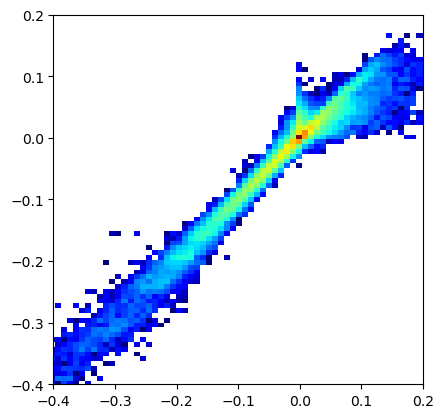

In [92]:
#plt.hist(sat_ratio,bins=100)
a=np.nonzero(y_test>-10)
print(np.corrcoef(y_test[a],y_[a]))
ax=plt.subplot(111)
h2=plt.hist2d(y_test[a]*2e3,y2_[a],bins=100,cmap='jet',norm=matplotlib.colors.LogNorm())
print(y_test[a].mean(),y_[a].mean()/2e3)
plt.xlim(-0.4,0.2)
plt.ylim(-0.4,0.2)
ax.set_aspect('equal')
#lgb_model.save('lgb_model.txt')
print(dir(lgb_model))

In [116]:
from catboost import CatBoostRegressor
cat_model2 = CatBoostRegressor(iterations=500,
                          learning_rate=0.1,
                          loss_function= 'MultiRMSE', 
                          eval_metric='MultiRMSE', 
                          depth=10)
print(ym_train.std(axis=0))
ym_std=ym_train.std(axis=0)
ym_train_scaled=ym_train.copy()/ym_std
cat_model2.fit(x_train,ym_train_scaled[:,0:2],verbose=True)

[1.2673428e-05 3.8572364e-02 1.6264565e+00]
0:	learn: 1.3079533	total: 797ms	remaining: 6m 37s
1:	learn: 1.2046066	total: 1.4s	remaining: 5m 49s
2:	learn: 1.1116432	total: 1.9s	remaining: 5m 14s
3:	learn: 1.0304447	total: 2.4s	remaining: 4m 57s
4:	learn: 0.9576931	total: 2.9s	remaining: 4m 47s
5:	learn: 0.8950065	total: 3.4s	remaining: 4m 39s
6:	learn: 0.8382602	total: 3.89s	remaining: 4m 33s
7:	learn: 0.7873509	total: 4.38s	remaining: 4m 29s
8:	learn: 0.7430209	total: 4.87s	remaining: 4m 25s
9:	learn: 0.7048513	total: 5.38s	remaining: 4m 23s
10:	learn: 0.6722560	total: 5.88s	remaining: 4m 21s
11:	learn: 0.6410373	total: 6.39s	remaining: 4m 19s
12:	learn: 0.6143486	total: 6.89s	remaining: 4m 18s
13:	learn: 0.5924311	total: 7.38s	remaining: 4m 16s
14:	learn: 0.5725888	total: 7.88s	remaining: 4m 14s
15:	learn: 0.5543124	total: 8.38s	remaining: 4m 13s
16:	learn: 0.5397655	total: 8.89s	remaining: 4m 12s
17:	learn: 0.5267834	total: 9.4s	remaining: 4m 11s
18:	learn: 0.5155129	total: 9.91s	re

In [120]:
cat_model2.save_model('cat_model2.json',format='json')
import pickle
pickle.dump({"ym_std":ym_std},open('ym_std.pkl','wb'))

In [95]:
print(histGradRegressor)
print(dir(histGradRegressor))
print(histGradRegressor._bin_data)

HistGradientBoostingRegressor(max_iter=3000)
['_VALID_LOSSES', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_baseline_prediction', '_bin_data', '_bin_mapper', '_check_categories', '_check_early_stopping_loss', '_check_early_stopping_scorer', '_check_feature_names', '_check_n_features', '_clear_state', '_compute_partial_dependence_recursion', '_encode_y', '_estimator_type', '_get_loss', '_get_param_names', '_get_small_trainset', '_get_tags', '_is_fitted', '_loss', '_more_tags', '_n_features', '_predict_iterations', '_predictors', '_print_iteration_stats', '_random_seed', '_raw_predict', '_repr_html_', '_repr_html

In [99]:
df=(lgb_model.booster_.trees_to_dataframe())
print(df)

       tree_index  node_depth node_index left_child right_child parent_index  \
0               0           1       0-S0       0-S7        0-S1         None   
1               0           2       0-S7       0-S8       0-S15         0-S0   
2               0           3       0-S8      0-S29       0-S12         0-S7   
3               0           4      0-S29       0-L0       0-L30         0-S8   
4               0           5       0-L0       None        None        0-S29   
...           ...         ...        ...        ...         ...          ...   
60995         999           9    999-S28    999-L28     999-L29      999-S27   
60996         999          10    999-L28       None        None      999-S28   
60997         999          10    999-L29       None        None      999-S28   
60998         999           7    999-L20       None        None      999-S19   
60999         999           5    999-L14       None        None      999-S13   

      split_feature   split_gain  thres

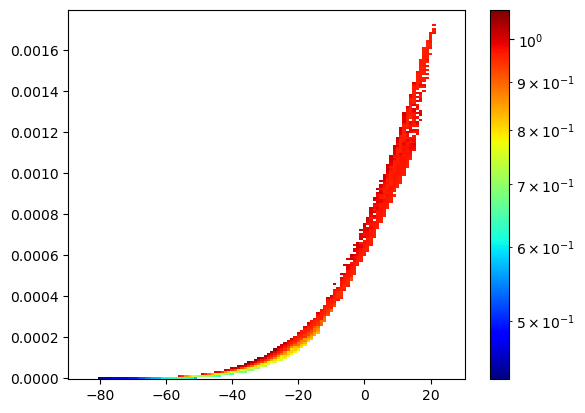

In [32]:
temp_def=30-np.arange(120)
q_def=0.00001*np.arange(180)
import matplotlib
#plt.pcolormesh(temp_def,q_def,-cond.T,cmap='jet',norm=
#               matplotlib.colors.LogNorm())
plt.pcolormesh(temp_def,q_def,cond_qvqvs.T,cmap='jet',norm=
               matplotlib.colors.LogNorm())
plt.colorbar()

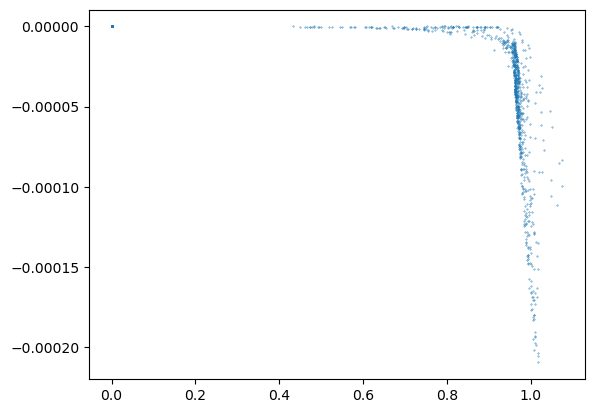

In [33]:
plt.scatter(cond_qvqvs.flatten(),cond.flatten(),s=0.1)

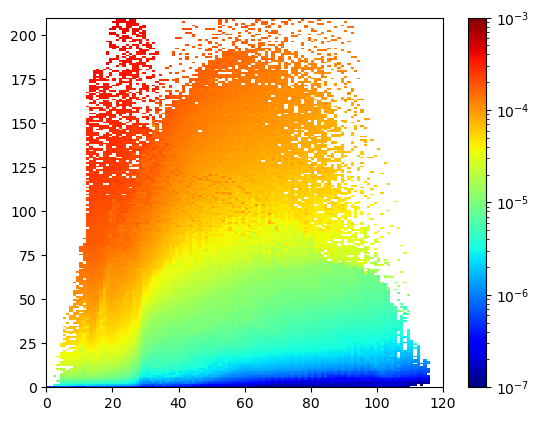

In [39]:
cfluxTb.max()

import matplotlib
plt.pcolormesh(fluxTb.T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-7,vmax=1e-3))
plt.colorbar()

In [40]:
a0=[[],[]]
x=[]
y=[]
for i in range(120):
    for j in range(210):
        if cfluxTb[i,j]>0:
            x.append([i,j])
            y.append(fluxTb[i,j])
        else:
            a0[0].append(i)
            a0[1].append(j)
a0=np.array(a0)


(2, 9525)


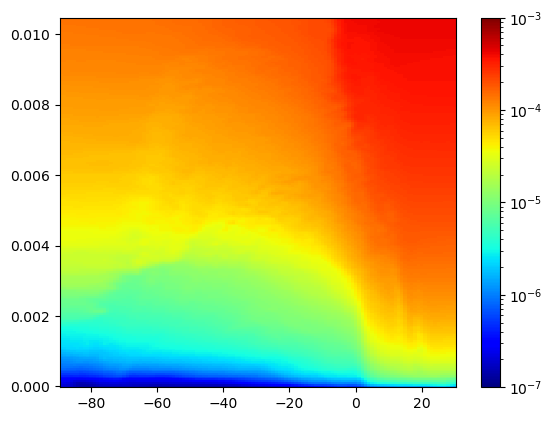

In [41]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

knn=KNeighborsRegressor(n_neighbors=10)
knn.fit(x,y)
print(a0.shape)
y_pred=knn.predict(a0.T)

fluxTb_interp=fluxTb.copy()
fluxTb_interp[a0[0],a0[1]]=y_pred
#plt.pcolormesh(fluxTb_interp.T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-7,vmax=1e-3))
from scipy.ndimage import gaussian_filter
fluxTb_interp=gaussian_filter(fluxTb_interp,sigma=1)
temp_def=30-np.arange(120)
q_def=0.00005*np.arange(210)
plt.pcolormesh(temp_def,q_def,fluxTb_interp.T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-7,vmax=1e-3))
plt.colorbar()

In [43]:
import xarray as xr

ds=xr.Dataset({'fluxTable':(['temp','q'],fluxTb_interp)},coords={'temp':temp_def,'q':q_def}) 
ds.to_netcdf('precipFluxTable.nc')

In [101]:
r=np.random.random(len(a[0]))
b=np.nonzero(r<0.2)
y1=[]
y2=[]
for it,i1,j1,k1 in zip(a[0][b],a[1][b],a[2][b],a[3][b]):
    it1=int((-x_phy[it,i1,j1,k1,1])+30)
    iq=int(x_phy[it,i1,j1,k1,2]/0.00005)
    
    if iq<0:
        iq=0
    if iq>179:
        iq=179
    if it1<0:
        it1=0
    if it1>119:
        it1=199
    y1.append(fluxTb_interp[it1,iq])
    y2.append(dq_dt[it,i1,j1,k1])

In [102]:
print(np.corrcoef(y1,y2))

[[1.         0.95620942]
 [0.95620942 1.        ]]


In [50]:

index_train, index_test = train_test_split(np.arange(x.shape[0]), test_size=0.2, random_state=42)
print(x.shape,y.shape)
print(index_train.shape)
#print(index_train)
#print(x[index_train[0]].shape)
print(index_train[0].shape)
x_train=x[index_train,:64,:].reshape(index_train.shape[0]*64,4).copy()
y_train=y[index_train,:64].reshape(index_train.shape[0]*64,1).copy()
x_test=x[index_test,:64,:].reshape(index_test.shape[0]*64,4).copy()
y_test=y[index_test,:64].reshape(index_test.shape[0]*64,1).copy()


from sklearn.cluster import MiniBatchKMeans

kmeans=MiniBatchKMeans(n_clusters=150,batch_size=1024)
kmeans.fit(x_train)

(307200, 86, 4) (307200, 64)
(245760,)
()


MiniBatchKMeans(n_clusters=150)

In [51]:
print(x_test.shape,y_test.shape)
yclass=np.zeros((150),float)
for i in range(150):
    a=np.where(kmeans.labels_==i)
    yclass[i]=np.mean(y_train[a])

labels_=kmeans.predict(x_test)
y_pred=yclass[labels_]


(3932160, 4) (3932160, 1)


In [52]:
kgainL=[]
nx=x_train.shape[1]
xobs_m=[]
flux_m=[]
nC=150
for i in range(nC):
    a=np.nonzero(kmeans.labels_==i)
    xk=x_train[a[0],:]
    yk=y_train[a[0],:]
    covXY=np.cov(xk.T,yk.T)
    covXX=covXY[:nx,:nx]+0.01*np.eye(nx)
    covYX=covXY[nx:,:nx]
    invCovXX=np.linalg.pinv(covXX)
    kgain=np.dot(covYX,invCovXX)
    kgainL.append(kgain)
    xobs_m.append(np.mean(xk,axis=0))
    flux_m.append(np.mean(yk,axis=0))

In [53]:
y_=[]
for i, x1 in enumerate(x_test):
    y_.append(np.dot(kgainL[labels_[i]],x1-xobs_m[labels_[i]])+flux_m[labels_[i]])

In [42]:
print(len(y_))
print(y_[0])
print(np.corrcoef(10**np.array(y_)[:,0],10**y_test[:,0]))

3932160
[3.6951565120171896e-05]
[[1.         0.93171496]
 [0.93171496 1.        ]]


In [25]:

training_set = TensorDataset(torch.from_numpy(x_train[a[0],:]).float(), torch.from_numpy(y_train[a[0],:]).float())
data_loader = DataLoader(training_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

In [82]:
#import optimizer
from torch import optim
# define optimizer
optimizer = optim.Adam(model_sed.parameters(), lr=0.001)
# define loss function
loss=nn.MSELoss()
# define number of epochs
n_epochs = 1
# empty list to store training losses
train_losses = []
# training loop
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    for data, target in data_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_sed(data)
        # calculate the loss
        target=target.squeeze()
        loss_output=loss(output.squeeze(), target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss_output.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss_output.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(data_loader.dataset)
    train_losses.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 0.000240


In [83]:
#save the model
torch.save(model_sed.state_dict(), 'model_sed_GC.pth')
torch.save(model_sed, 'model_sed_GC_all.pth')

In [84]:
# load the saved model
model_sed2=torch.load('model_sed_GC_all.pth')
y_test_=model_sed2(torch.from_numpy(x_test).float()).detach().numpy()

In [85]:
y_=10**(np.exp(y_test_)-1)*1e-4
print(y_.shape)
print(x_test.shape)
print(y_test.shape)
y_test_r=10**(np.exp(y_test)-1)*1e-4
#plt.scatter(y_,y_test_r)
print(np.corrcoef(y_.flatten(),y_test_r.flatten()))



(3932160, 1)
(3932160, 4)
(3932160, 1)
[[1.         0.97535554]
 [0.97535554 1.        ]]


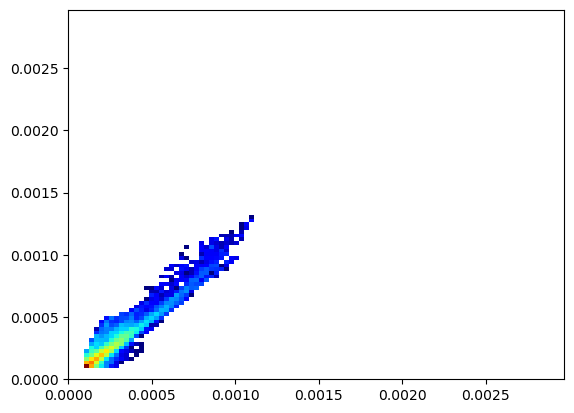

In [39]:
import matplotlib
h1=plt.hist2d(y_.flatten(),y_test_r.flatten(),bins=np.arange(100)*3e-3/100,cmap="jet",norm=matplotlib.colors.LogNorm())

In [87]:
print(x_test.shape[0]/64)
x2d_test=x_test.reshape(x_test.shape[0]//64,64,-1)
print(x2d_test.shape)

61440.0
(61440, 64, 4)


In [95]:
#x=np.stack([prs_reshaped/1e5,(th3d_reshaped-273.15)/10,np.log10(1+q3d_reshaped/1e-4),w3d_reshaped[:,:-1]/10.],axis=-1)
#q_test=(10**x_test[:,:,2][:,::-1]-1)*1e-4
#x_test_iterated=x_test.copy()
#print(x_test.shape)
#plt.plot(q_test[:,:].mean(axis=0),zh[:64])

#q0=(10**x_test[:,:,2][:,::-1]-1)*1e-4
#q1=q0.copy()
#qL=[]
rho_avg=rho.mean(axis=(0,1,2))
print(rho_avg.shape)

(86,)


(61440, 64)


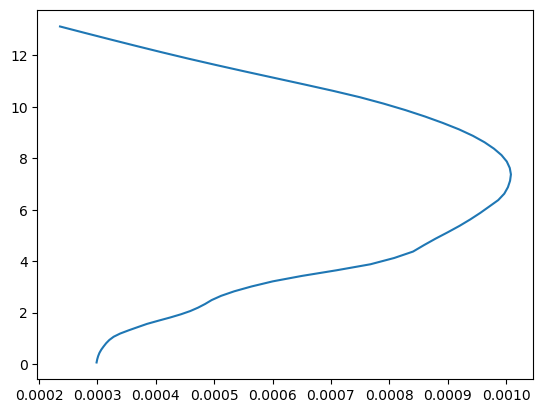

In [121]:
x2d_iterated=x2d_test.copy()
x_test_iterated=np.reshape(x2d_iterated,(x2d_iterated.shape[0]*64,-1))
nn_fluxes=model_sed2(torch.from_numpy(x_test_iterated).float())[:,0].detach().numpy()
q0=(10**x2d_iterated[:,:,2].copy()-1)*1e-4
print(q0.shape)
plt.plot(q0[:,:].mean(axis=0),zh[:64])

In [122]:

q1=q0.copy()
qL=[]
import tqdm
for it in tqdm.tqdm(range(300)):
    #flux=((10**y_test_-1)*1e-4)[:,::-1]
    flux=((10**nn_fluxes-1)*1e-4).reshape(x2d_iterated.shape[0],64)
    for i in range(62,-1,-1):
        q1[:,i]=q0[:,i]+2*(-flux[:,i]+flux[:,i+1])/dz[i]/rho_avg[i]
    q1[:,63]=q0[:,63]-2*flux[:,63]/dz[63]
    q1[q1<0]=0
    x2d_iterated[:,:,2]=np.log10(1+q1/1e-4)[:]
    x_test_iterated=np.reshape(x2d_iterated,(x2d_iterated.shape[0]*64,-1))
    nn_fluxes=model_sed2(torch.from_numpy(x_test_iterated).float())[:,0].detach().numpy()
    q0=q1.copy()
    if it%10==0:
        qL.append(q0.mean(axis=0))

100%|██████████| 300/300 [00:58<00:00,  5.12it/s]


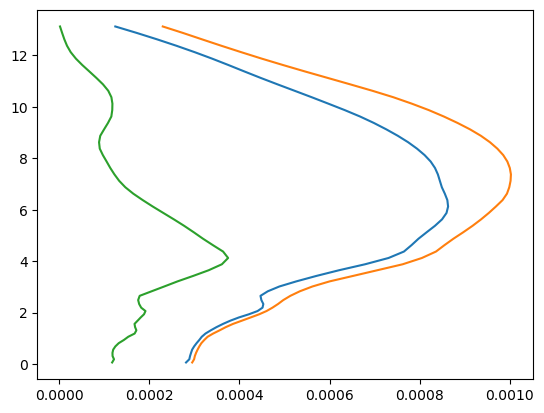

In [125]:
plt.plot(np.array(qL)[:7,:].mean(axis=0),zh[:64])
plt.plot(np.array(qL)[:1,:].mean(axis=0),zh[:64])
plt.plot(np.array(qL)[-2:,:].mean(axis=0),zh[:64])

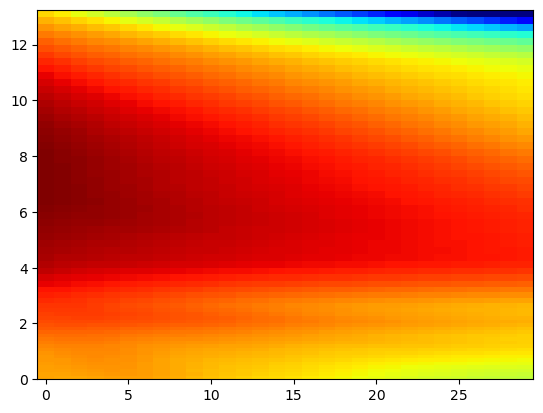

In [112]:
#print(x_reshaped.shape)
#plt.plot(qL[-1],zh[:64])
#plt.plot(zh[:64],x_reshaped[0,:64,2])
plt.pcolormesh(range(len(qL)),zh[:64],np.array(qL).T,cmap="jet",norm=matplotlib.colors.LogNorm(vmax=0.001,vmin=0.00001))

In [53]:
print(flux.shape)
print(q1.shape)

(61440, 64, 1)
(61440, 64)
